In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
# Load the dataset
file_path = 'data/gym_members_exercise_tracking.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
data.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [9]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

# Fill missing values with the mean for numerical columns
data.dropna(inplace=True)

Series([], dtype: int64)


In [10]:
# Define features and target variable
X = data.drop(columns=['Calories_Burned'])
y = data['Calories_Burned']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest Results:
MSE: 2334.80
R2: 0.97

Gradient Boosting Results:
MSE: 438.46
R2: 0.99


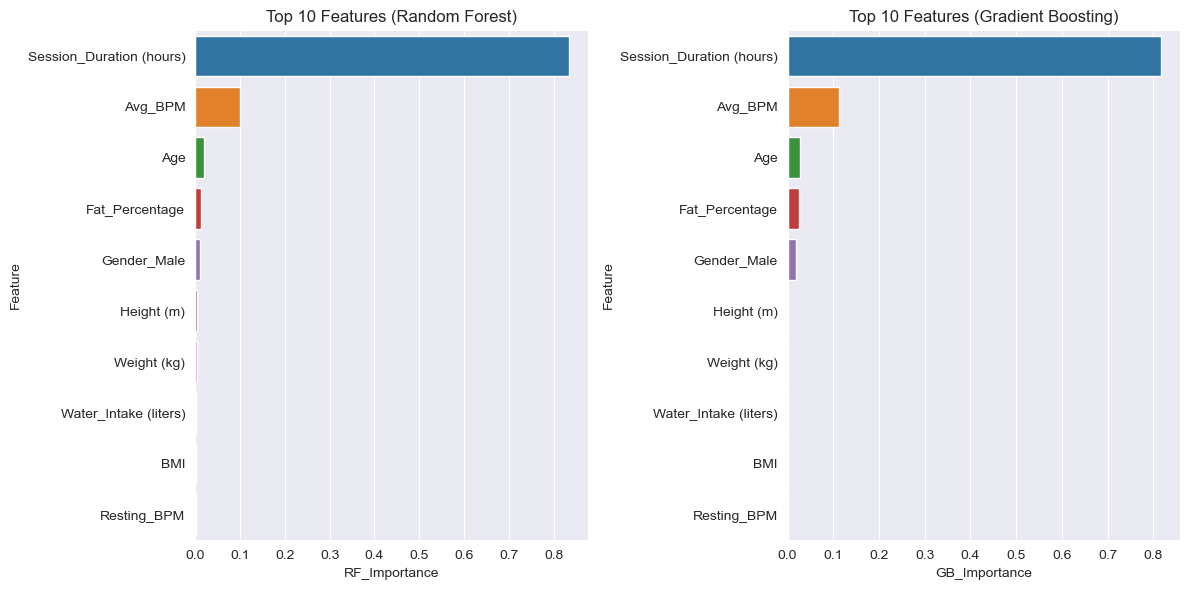

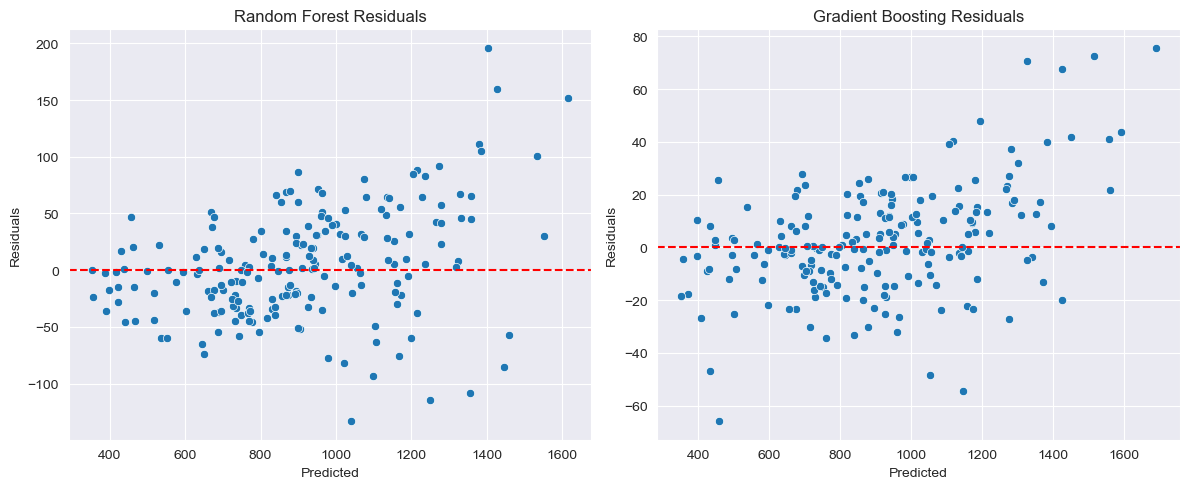


Ensemble Model Results:
MSE: 1037.01
R2: 0.99


In [2]:
# Save model and scaler


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# Load and preprocess data (same as before)
file_path = 'data/gym_members_exercise_tracking.csv'
data = pd.read_csv(file_path)

# Handle missing values
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=[object]).columns.tolist()
data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].mean())
for col in categorical_cols:
    mode_value = data[col].mode()[0]
    data[col] = data[col].fillna(mode_value)

# One-hot encoding
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Split features and target
X = data.drop(columns=['Calories_Burned'])
y = data['Calories_Burned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize both models
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Hyperparameter grids for both models
rf_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

# Tune both models
rf_random = RandomizedSearchCV(rf_model, param_distributions=rf_param_dist, n_iter=20, cv=5, random_state=42)
gb_random = RandomizedSearchCV(gb_model, param_distributions=gb_param_dist, n_iter=20, cv=5, random_state=42)

rf_random.fit(X_train_scaled, y_train)
gb_random.fit(X_train_scaled, y_train)

# Get best models
best_rf = rf_random.best_estimator_
best_gb = gb_random.best_estimator_

# Make predictions
rf_pred = best_rf.predict(X_test_scaled)
gb_pred = best_gb.predict(X_test_scaled)

# Calculate metrics for both models
print("Random Forest Results:")
print(f'MSE: {mean_squared_error(y_test, rf_pred):.2f}')
print(f'R2: {r2_score(y_test, rf_pred):.2f}')
print("\nGradient Boosting Results:")
print(f'MSE: {mean_squared_error(y_test, gb_pred):.2f}')
print(f'R2: {r2_score(y_test, gb_pred):.2f}')

# Feature importance comparison
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': best_rf.feature_importances_
})

gb_importance = pd.DataFrame({
    'Feature': X.columns,
    'GB_Importance': best_gb.feature_importances_
})

# Merge importance scores
importance_comparison = rf_importance.merge(gb_importance, on='Feature')
importance_comparison['Mean_Importance'] = (importance_comparison['RF_Importance'] + 
                                          importance_comparison['GB_Importance']) / 2
importance_comparison = importance_comparison.sort_values('Mean_Importance', ascending=False)

# Visualize feature importance comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='RF_Importance', y='Feature', data=importance_comparison.head(10))
plt.title('Top 10 Features (Random Forest)')

plt.subplot(1, 2, 2)
sns.barplot(x='GB_Importance', y='Feature', data=importance_comparison.head(10))
plt.title('Top 10 Features (Gradient Boosting)')
plt.tight_layout()
plt.show()

# Compare residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=rf_pred, y=y_test-rf_pred)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Random Forest Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.scatterplot(x=gb_pred, y=y_test-gb_pred)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gradient Boosting Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

# Create ensemble prediction (average of both models)
ensemble_pred = (rf_pred + gb_pred) / 2
print("\nEnsemble Model Results:")
print(f'MSE: {mean_squared_error(y_test, ensemble_pred):.2f}')
print(f'R2: {r2_score(y_test, ensemble_pred):.2f}')

In [4]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_scores = -cv_scores

print(f'Cross-validated MSE: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}')

Cross-validated MSE: 1916.66 ± 305.52
